# Forecast

Different statistical model can be built for different clusters of households. Forecasts with two different resolutions, hourly and daily, are expected.

In [ ]:
#hide
from elec_consumption.utils import ContextTimer
import datetime
from fbprophet import Prophet
from loguru import logger
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
from pandas._libs.tslibs.timestamps import Timestamp
import seaborn as sns

Importing plotly failed. Interactive plots will not work.


In [ ]:
#hide
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [6 * 1.61803398875, 6]
_seed = 123  # for clustering analysis
data = {}  # contain modified dataframes

In [ ]:
#hide
# Import 500 profiles.
df = pd.read_csv('./data/raw.csv', index_col=0)
df.columns = list(range(df.shape[1]))
df.columns.name = 'household'
df.index = pd.to_datetime(df.index)
df.index.name = 'datetime'

## 1. Prophet for Daily Profile of Household 1

In [ ]:
#hide
ts_fb = df.iloc[:, 0].resample('1D', closed='left').mean()  # to pandas time series
ts_fb = ts_fb.to_frame().reset_index()  # to Prophet time series
ts_fb.columns = ['ds', 'y']

In [ ]:
#hide
mod = Prophet()
mod.fit(ts_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forcast values in future 3 days.

In [ ]:
#hide
future = mod.make_future_dataframe(periods=3)
forecast = mod.predict(future)

In [ ]:
#hide_input
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

,ds,yhat,yhat_lower,yhat_upper
122,2017-12-01,0.135803,0.085782,0.180520
123,2017-12-02,0.159741,0.111749,0.203637
124,2017-12-03,0.154350,0.109334,0.202848


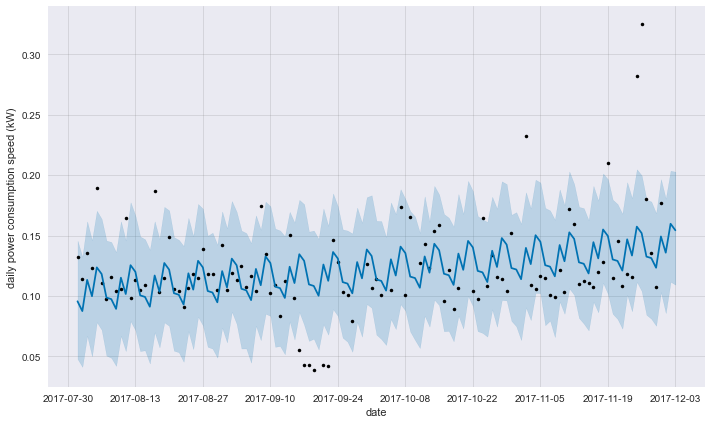

In [ ]:
##hide_input
mod.plot(forecast, xlabel='date', ylabel='daily power consumption speed (kW)');

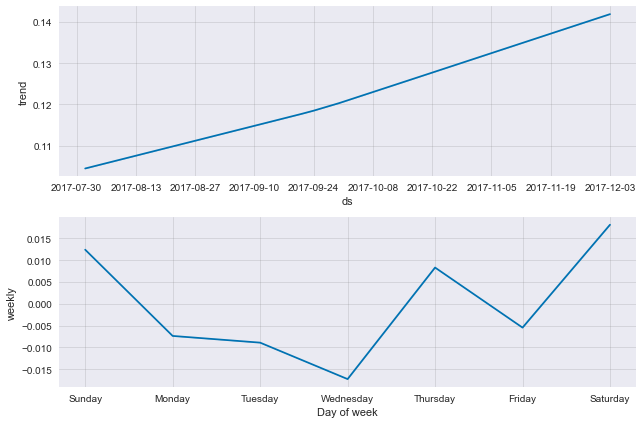

In [ ]:
#hide_input
mod.plot_components(forecast);

## 2. Prophet for Hourly Profile of Household 1

In [ ]:
#hide
ts_pd = df.iloc[:, 0].resample('1H', closed='left').mean()  # to pandas time series
ts_fb = ts_pd.to_frame().reset_index()  # to Prophet time series
ts_fb.columns = ['ds', 'y']
mod = Prophet()
mod.fit(ts_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
#hide
future = mod.make_future_dataframe(periods=24, freq='H', include_history=True)
forecast = mod.predict(future)

In [ ]:
#hide_input
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

,ds,yhat,yhat_lower,yhat_upper
2949,2017-12-01 21:00:00,0.165256,0.015078,0.302608
2950,2017-12-01 22:00:00,0.163413,0.031439,0.297429
2951,2017-12-01 23:00:00,0.162393,0.023910,0.295843


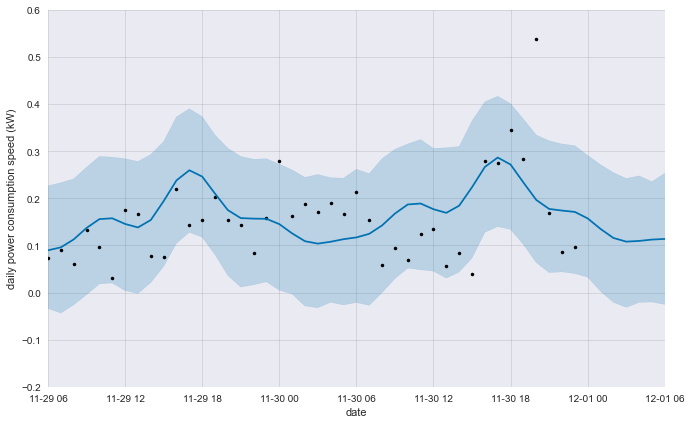

In [ ]:
##hide_input
_, ax = plt.subplots(1, 1)
ax.set_xlim([Timestamp('2017-11-29 06:00:00'), Timestamp('2017-12-01 06:00:00')])
ax.set_ylim([-0.2, 0.6])
mod.plot(forecast, ax=ax, xlabel='date', ylabel='daily power consumption speed (kW)');